# Linear PTO

### Options

In [1]:
# linear_pto = False
# fconstraint = False
# electric_power = False
# scale_x_wec = 1.0
# scale_x_opt = 100.0
# scale_obj = 1.0


# linear_pto = False
# fconstraint = True
# electric_power = False
# scale_x_wec = 1.0
# scale_x_opt = 0.01
# scale_obj = 1.0

linear_pto = True
fconstraint = False
electric_power = True
scale_x_wec = 1.0
scale_x_opt = 1.0
scale_obj = 1.0

# linear_pto = True
# fconstraint = True
# electric_power = True
# scale_x_wec = 1.0
# scale_x_opt = 1.0
# scale_obj = 1.0


### Run

In [2]:
import os
import logging

import matplotlib.pyplot as plt
import capytaine as cpy
from autograd.builtins import isinstance, tuple, list, dict
import autograd.numpy as np

import wecopttool as wot


# logging 
logging.basicConfig(level=logging.INFO)

# create save directory
results_dir = 'results_linear_pto'
if not os.path.exists(results_dir):
  os.makedirs(results_dir)

## WEC object
# mesh
wb = wot.geom.WaveBot()  # use standard dimensions
mesh_size_factor = 0.5  # 1.0 for default, smaller to refine mesh
mesh = wb.mesh(mesh_size_factor)

# floating body
fb = cpy.FloatingBody.from_meshio(mesh, name="WaveBot")
fb.add_translation_dof(name="HEAVE")

# hydrostatics
hs_data = wot.hydrostatics.hydrostatics(fb)
mass_33 = wot.hydrostatics.mass_matrix_constant_density(hs_data)[2, 2]
mass = np.atleast_2d(mass_33)
stiffness_33 = wot.hydrostatics.stiffness_matrix(hs_data)[2, 2]
stiffness = np.atleast_2d(stiffness_33)

# frequencies
f0 = 0.05
nfreq = 50

# PTO kinematics
kinematics = np.eye(fb.nb_dofs)

# PTO dynamics
if linear_pto:
    gear_ratio = 12.4666
    torque_constant = 6.1745
    electrical_constant = 4.116
    winding_resistance = 0.5
    dynamics = np.array([[0.0, torque_constant*gear_ratio],
                        [electrical_constant*gear_ratio, winding_resistance]])
else:
    dynamics = np.array([[0.0, 1.0], [0.0, 0.0]])

# PTO
pto = wot.pto.PseudoSpectralLinearPTO(nfreq, kinematics, dynamics)

# constraints
if fconstraint:
    f_max = 2000.0
    nsubsteps = 4

    def const_f_pto(wec, x_wec, x_opt):
        f = pto.force_on_wec(wec, x_wec, x_opt, nsubsteps)
        return f_max - np.abs(f.flatten())

    ineq_cons = {'type': 'ineq',
                 'fun': const_f_pto,
                 }
    constraints = [ineq_cons]
else:
    constraints = []

# additional dynamics forces function
f_add = pto.force_on_wec

# WEC object
wec = wot.WEC(fb, mass, stiffness, f0, nfreq,
              f_add=f_add, constraints=constraints)

# BEM
fname = os.path.join(results_dir, 'bem.nc')
if os.path.exists(fname):
    wec.read_bem(fname)
else:
    wec.run_bem()
    wec.write_bem(fname)

# waves
wfreq = 0.3
amplitude = 0.0625
phase = -40
waves = wot.waves.regular_wave(f0, nfreq, wfreq, amplitude, phase)

# objective function
if electric_power:
    obj_fun = pto.electric_average_power
else:
    obj_fun = pto.average_power
nstate_opt = pto.nstate

# solve
options = {'maxiter': 1000, 'ftol': 1e-8}

wec_tdom, wec_fdom, x_wec, x_opt, obj, res = wec.solve(
    waves, obj_fun, nstate_opt, optim_options=options,
    scale_x_wec=scale_x_wec, scale_x_opt=scale_x_opt, scale_obj=scale_obj)

# post-process
pto_tdom, pto_fdom = pto.post_process(wec, x_wec, x_opt)

INFO:capytaine.bodies.bodies:Stored 1054 triangle faces as quadrilaterals
INFO:capytaine.bodies.bodies:New floating body: WaveBot.
INFO:wecopttool.core:New WEC: WaveBot with 1 DOF.
INFO:wecopttool.core:Reading BEM data from results_linear_pto/bem.nc.
INFO:wecopttool.core:Impedance matrix deleted. To calculate impedance call 'self.bem_calc_impedance()'
INFO:wecopttool.core:Impedance matrix deleted. To calculate impedance call 'self.bem_calc_impedance()'
INFO:wecopttool.core:Calculating impedance matrix.
INFO:capytaine.post_pro.impedance:Compute impedance.
INFO:wecopttool.core:Solving pseudo-spectral control problem.
INFO:wecopttool.core:Optimization terminated successfully    (Exit mode 0)


Optimization terminated successfully    (Exit mode 0)
            Current function value: -8.401615959722692
            Iterations: 20
            Function evaluations: 24
            Gradient evaluations: 20


### CC (Mechanical) Solution
Optimal solution for maximum mechanical power, no constraints.

In [3]:
# CC solution
idof = 0
Fe = wec_fdom['excitation_force'][1:, idof]
Zi = wec.hydro.Zi[:, idof, idof]

cc_vel_fd = Fe / (2*Zi.real)
cc_force_fd = -1.0 * Zi.conj() * cc_vel_fd

cc_vel_td = wot.post_process_continuous_time(cc_vel_fd)
cc_force_td = wot.post_process_continuous_time(cc_force_fd)

### CC (Electrical) Solution
Optimal solution for maximum mechanical power, no constraints.

In [12]:
Z_11, Z_12  = dynamics[0, :] 
Z_21, Z_22  = dynamics[1, :]
V_th = Z_21 / (Z_11 + Zi) * Fe
Z_th = Z_22 - (Z_12*Z_21)/(Z_11+Zi)

cc_current_fd = V_th / (2*Z_th.real)
cc_voltage_fd = -1.0 * Z_th.conj() * cc_current_fd

cc_current_td = wot.post_process_continuous_time(cc_current_fd)
cc_voltage_td = wot.post_process_continuous_time(cc_voltage_fd)


### Results

In [13]:
# print
print(f"Average mechanical power: {pto.average_power(wec, x_wec, x_opt)} W")
print(f"Average electrical power: {pto.electric_average_power(wec, x_wec, x_opt)} W\n")

Average mechanical power: -24.07227650888629 W
Average electrical power: -8.401615959722692 W



Text(0, 0.5, 'mechanical power [W]')

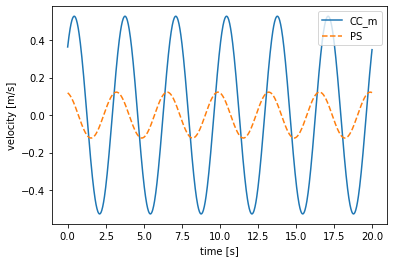

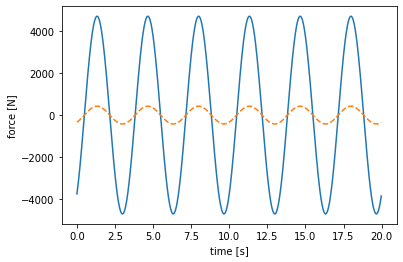

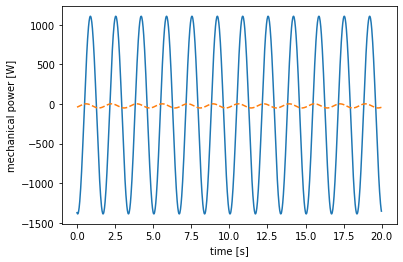

In [14]:
nsubsteps = 10

t = wec.make_time_vec(nsubsteps)

# plot mechanical power
plt.figure()
plt.plot(t, cc_vel_td(t), '-', label='CC_m')
plt.plot(t, pto.velocity(wec, x_wec, x_opt, nsubsteps), '--', label='PS')
plt.xlabel('time [s]')
plt.ylabel('velocity [m/s]')
plt.legend()

plt.figure()
plt.plot(t, cc_force_td(t), '-')
plt.plot(t, pto.force(wec, x_wec, x_opt, nsubsteps), '--')
plt.xlabel('time [s]')
plt.ylabel('force [N]')

plt.figure()
plt.plot(t, cc_vel_td(t)*cc_force_td(t), '-')
plt.plot(t, pto.power(wec, x_wec, x_opt, nsubsteps), '--')
plt.xlabel('time [s]')
plt.ylabel('mechanical power [W]')


Text(0, 0.5, 'electrical power [W]')

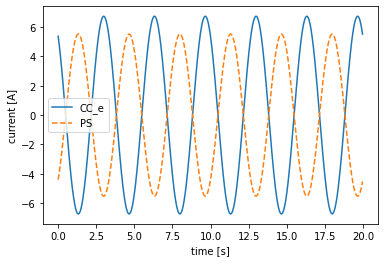

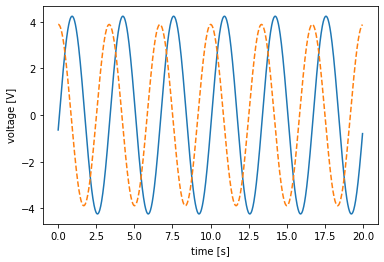

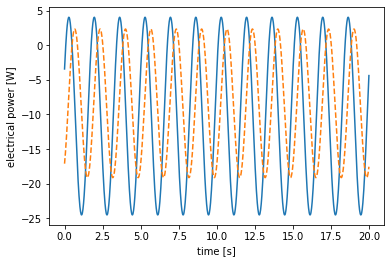

In [15]:
# plot electrical power
plt.figure()
plt.plot(t, cc_current_td(t), '-', label='CC_e')
plt.plot(t, pto.electric_current(
    wec, x_wec, x_opt, nsubsteps), '--', label='PS')
plt.xlabel('time [s]')
plt.ylabel('current [A]')
plt.legend()

plt.figure()
plt.plot(t, cc_voltage_td(t), '-')
plt.plot(t, pto.electric_voltage(wec, x_wec, x_opt, nsubsteps), '--')
plt.xlabel('time [s]')
plt.ylabel('voltage [V]')

plt.figure()
plt.plot(t, cc_current_td(t)*cc_voltage_td(t), '-')
plt.plot(t, pto.electric_power(wec, x_wec, x_opt, nsubsteps), '--')
plt.xlabel('time [s]')
plt.ylabel('electrical power [W]')
